# Evolution of Learning

The model extends the model from [Xue & Leibler, PNAS 2016](http://www.pnas.org/lookup/doi/10.1073/pnas.1608756113).

At each generation:

1. individuals develop a phenotype according to their phenotype distribution $\pi$: $\pi_i \in [0,1]$ is the probability that a specific individual will develop to phenotype $\phi_i$.
1. the fitness of individuals is set according to their phenotype and the environment $\epsilon \in {0, 1}$.
. individuals reproduce: the relative contribution (fitness) of individuals with phenotype $\phi_i$ in environment $\epsilon_j$ to the next generation is $\frac{\omega_i^{(j)}}{\sum_k{\phi_k^j}}$.
1. each offspring phenotype distribution is inherited from its parent, where a fraction $1-\eta$ is determined according to the parent phenotype distribution and a fraction $\eta$ is determined according to the parent phenotype; the offspring distribution is $\pi_i' = (1-\eta)\phi_i + \eta * \delta_{i,k}$, where $k$ is the parent phenotype.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='ticks', context='paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)
from simulation import *

# Figure 2

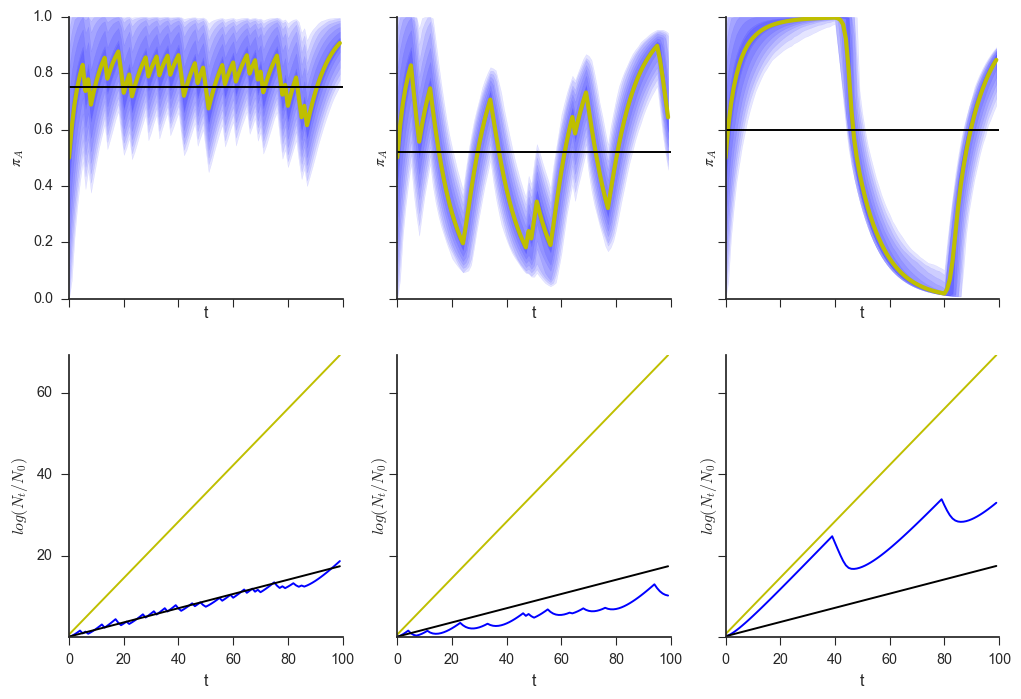

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey='row')

N=100000
n=100
η=0.1
μ=0
ω0=2
ω1=0.2
π0=0.5
p0 = 0.5

## Fig. 2A
ϵ = np.random.choice(2, n, True, [0.7, 0.3])
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0, 0])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,0])

## Fig. 2B
ϵ, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵ[a: a + g] = 1
    a += g
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0,1])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,1])

## Fig. 2C
ϵ = np.array([0] * 40 + [1] * 40 + [0] * 20)
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0,2])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,2]);

# Modifier competitions in Fig. 2

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(16, 8), sharex=True, sharey='row')

N=100000
n=500
η1=0.1
η2=0
μ1=0
μ2=0.1
ω0=2
ω1=0.2
π0=0.5
p0 = 0.5
κ = 0

## Fig. 2A
ϵ = np.random.choice(2, n, True, [0.7, 0.3])
π, η_bar, μ_bar= simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵ)
plot_π(π, ϵ, ax=ax[0, 0])
plot_η(η_bar, η1, η2, ax=ax[1, 0])
plot_μ(μ_bar, μ1, μ2, ax=ax[2, 0])

## Fig. 2B
ϵ, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵ[a: a + g] = 1
    a += g
π, η_bar, μ_bar = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵ)
plot_π(π, ϵ, ax=ax[0, 1])
plot_η(η_bar, η1, η2, ax=ax[1, 1])
plot_μ(μ_bar, μ1, μ2, ax=ax[2, 1])

## Fig. 2C
ϵ = np.array(([0] * 40 + [1] * 40) * (n//80 + 1))
π, η_bar, μ_bar = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵ)
plot_π(π, ϵ, ax=ax[0, 2])
plot_η(η_bar, η1, η2, ax=ax[1, 2])
plot_μ(μ_bar, μ1, μ2, ax=ax[2, 2])

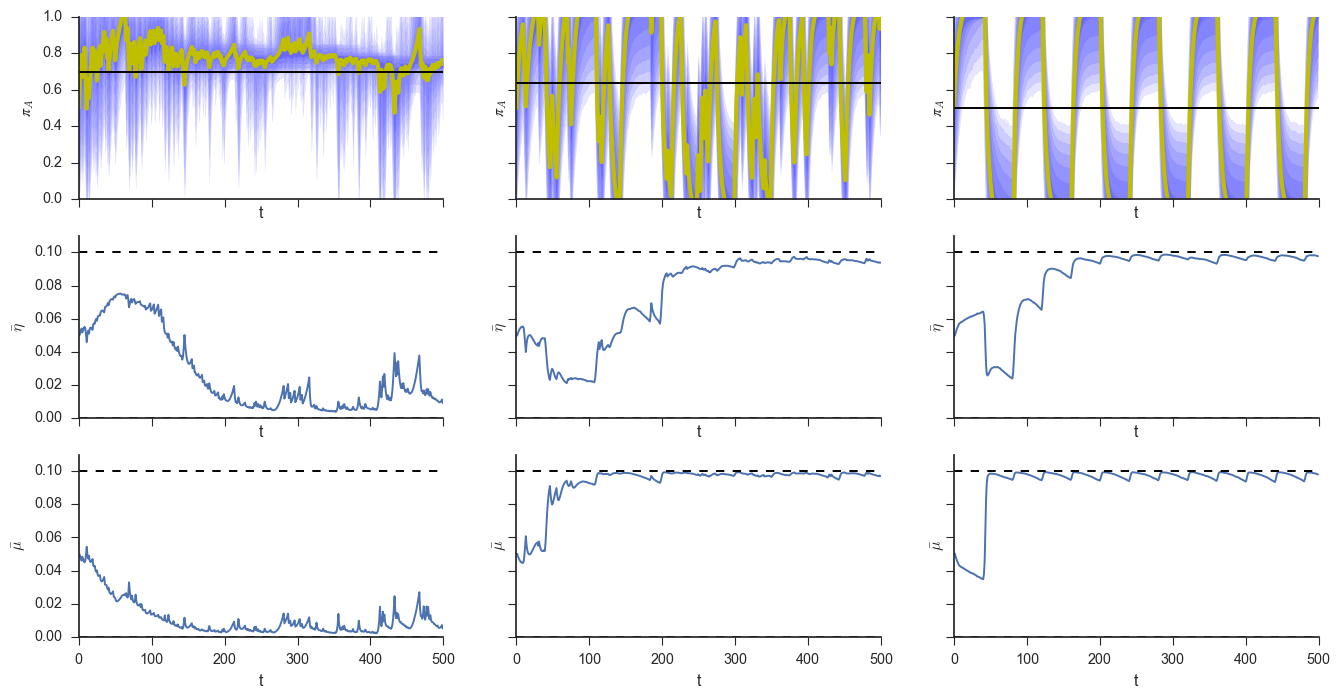

In [3]:
fig, ax = plt.subplots(3, 3, figsize=(16, 8), sharex=True, sharey='row')

N=100000
n=500
η1=0.1
η2=0
μ1=0
μ2=0.1
ω0=2
ω1=0.2
π0=0.5
p0 = 0.5
κ = 0.001

## Fig. 2A
ϵ = np.random.choice(2, n, True, [0.7, 0.3])
π, η_bar, μ_bar= simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵ)
plot_π(π, ϵ, ax=ax[0, 0])
plot_η(η_bar, η1, η2, ax=ax[1, 0])
plot_μ(μ_bar, μ1, μ2, ax=ax[2, 0])

## Fig. 2B
ϵ, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵ[a: a + g] = 1
    a += g
π, η_bar, μ_bar = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵ)
plot_π(π, ϵ, ax=ax[0, 1])
plot_η(η_bar, η1, η2, ax=ax[1, 1])
plot_μ(μ_bar, μ1, μ2, ax=ax[2, 1])

## Fig. 2C
ϵ = np.array(([0] * 40 + [1] * 40) * (n//80 + 1))
π, η_bar, μ_bar = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵ)
plot_π(π, ϵ, ax=ax[0, 2])
plot_η(η_bar, η1, η2, ax=ax[1, 2])
plot_μ(μ_bar, μ1, μ2, ax=ax[2, 2])

## Multiple simulations

Simuations ran with:

```
python simulation.py --N 100000 --n 500 --η1 0.1 --η2 0.2 --ω0 2.0 --ω1 0.2  --π0 0.5  --env A
```
and results were saved to `output` folder.

In [2]:
import glob
import os
import gzip
import warnings
import json

folder = 'output1'

In [34]:
πs = []
for filename in glob.glob(os.path.join(folder, 'π_*')):
    with gzip.open(filename, 'r') as f:
        πs.append( np.loadtxt(f, delimiter=', ') )
πs = np.array(πs)

In [36]:
ϵs = []
for filename in glob.glob(os.path.join(folder, 'ϵ_*')):
    with gzip.open(filename, 'r') as f:
        ϵs.append( np.loadtxt(f, delimiter=', ', dtype=float) )

In [38]:
ηs = []
for filename in glob.glob(os.path.join(folder, 'η_*')):
    with gzip.open(filename, 'r') as f:
        ηs.append( np.loadtxt(f, delimiter=', ') )    
ηs = np.array(ηs)

In [39]:
# μs = []
# for filename in glob.glob(os.path.join(folder, 'μ_*')):
#     with gzip.open(filename, 'r') as f:
#         μs.append( np.loadtxt(f, delimiter=', ') )    
# μs = np.array(μs)

In [40]:
params = []
for filename in glob.glob(os.path.join(folder, 'params_*')):
    with open(filename, 'r') as f:
        params.append( json.load(f) )

In [41]:
envs = np.array([p['env'] for p in params])
η1s = np.array([float(p['η1']) for p in params])
η2s = np.array([float(p['η2']) for p in params if p['η2']])

In [42]:
assert len(np.unique(η1s)) == 1
assert len(np.unique(η2s)) == 1
η1 = η1s[0]
η2 = η2s[0]

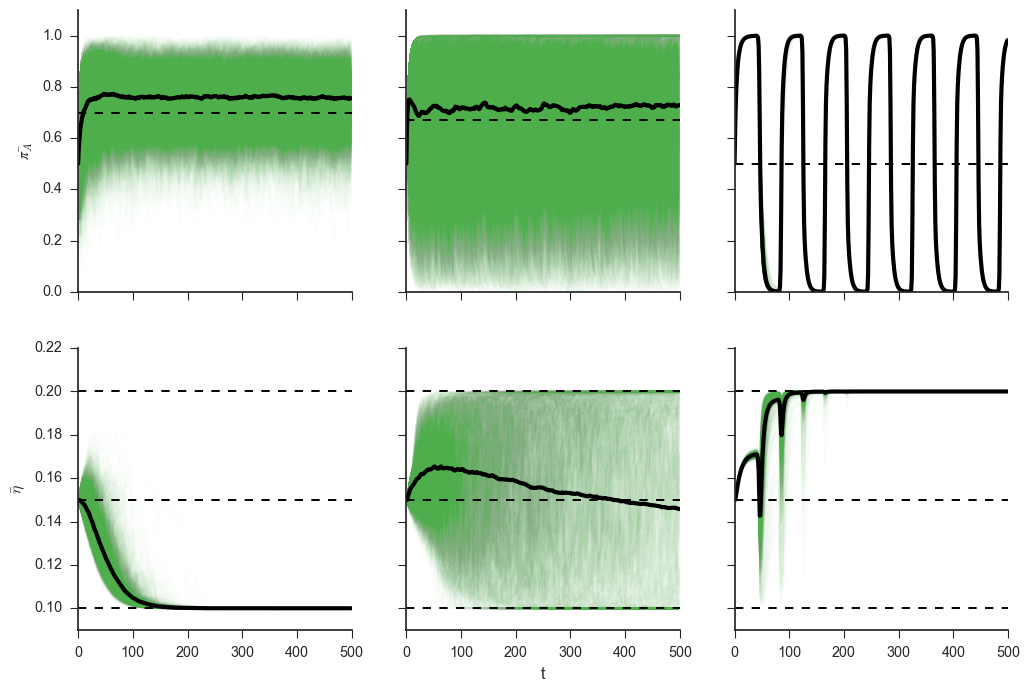

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey='row')

for i, env in enumerate(('A', 'B', 'C')):
    ax[0, i].plot(πs[envs==env, :].T, color=blue, alpha=0.01)
    ax[0, i].plot(πs[envs==env, :].mean(axis=0), lw=3, color='k', ls='-')
    p0 = np.mean([1 - x.mean() for i, x in enumerate(ϵs) if envs[i] == env])
    ax[0, i].axhline(p0, color='k', ls='--')
    ax[1, i].plot(ηs[envs==env, :].T, color=blue, alpha=0.01)
    ax[1, i].plot(ηs[envs==env, :].mean(axis=0), lw=3, color='k', ls='-')
    ax[1, i].axhline(η1, color='k', ls='--')
    ax[1, i].axhline(η2, color='k', ls='--')
    ax[1, i].axhline((η1 + η2)/2, color='k', ls='--')
ax[0,0].set(
    ylim=(0, 1.1),
    ylabel=r'$\bar{π_A}$'
)
ax[1,0].set(
    ylabel=r'$\bar{\eta}$',
    ylim=(0.9 * η1, η2 * 1.1)
)
ax[1,1].set(
    xlabel='t'
)
sns.despine()

In [92]:
fig.savefig("modifier_competition_1000.png")

## Using pandas and seaborn...

In [2]:
import glob
import os
import json
import gzip

In [3]:
def load_simulations(folder, load_η, load_μ):
    dfs = []
    for filename in glob.glob(os.path.join(folder, 'params*json')):
        filename = os.path.split(filename)[-1]
        filename = filename.replace('params_', '').replace('.json', '')
        try:
            params = read_json(folder, filename)
            π = read_csv_gz(folder, filename, 'π')
            ϵ = read_csv_gz(folder, filename, 'ϵ')
            if load_η:
                η = read_csv_gz(folder, filename, 'η')
            if load_μ:
                μ = read_csv_gz(folder, filename, 'μ')
        except IOError:
            print("Faled loading", filename)
            continue
        t = np.arange(len(π))
        ϵ = ϵ[:len(t)]
        data = dict(ID=filename, t=t, π=π, ϵ=ϵ, **params)
        if load_η:
            data['η'] = η
        if load_μ:
            data['μ'] = μ
        dfs.append(pd.DataFrame(data))
    return pd.concat(dfs)

In [68]:
df1 = load_simulations('output1', True, False)
df1.shape

(1499000, 13)

In [76]:
def plot_simulations(df):
    fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,6))
    samples = 10
    red, green, blue = sns.color_palette('Set1', 3)
    for i, env in enumerate(('A', 'B', 'C')):
        _df = df[df.env == env]
        ids = np.random.choice(_df.ID.unique(), samples)
        grp = _df[_df.ID.isin(ids)].groupby('ID')
        sns.tsplot(_df, time='t', unit='ID', value='π', lw=2, color=blue, ci=False, ax=ax[0, i])
        grp.plot('t', 'π', color=blue, alpha=2/samples, ax=ax[0, i])
        if 'η' in df.columns:
            sns.tsplot(_df, time='t', unit='ID', value='η', lw=2, color=green, ci=False, ax=ax[1, i])
            grp.plot('t', 'η', color=green, alpha=2/samples, ax=ax[1, i])
        if 'μ' in df.columns:
            sns.tsplot(_df, time='t', unit='ID', value='μ', lw=2, color=red, ci=False, ax=ax[2, i])
            grp.plot('t', 'μ', color=red, alpha=0.02, ax=ax[2, i])
        ax[0, i].axhline(1-_df.ϵ.mean(), color='k', ls='--')
        if ax[0, i].legend(): ax[0, i].legend().set_visible(False)
        if ax[1, i].legend(): ax[1, i].legend().set_visible(False)
        if ax[2, i].legend(): ax[2, i].legend().set_visible(False)

    sns.despine()
    return ax

/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  'cannot be automatically added to the '


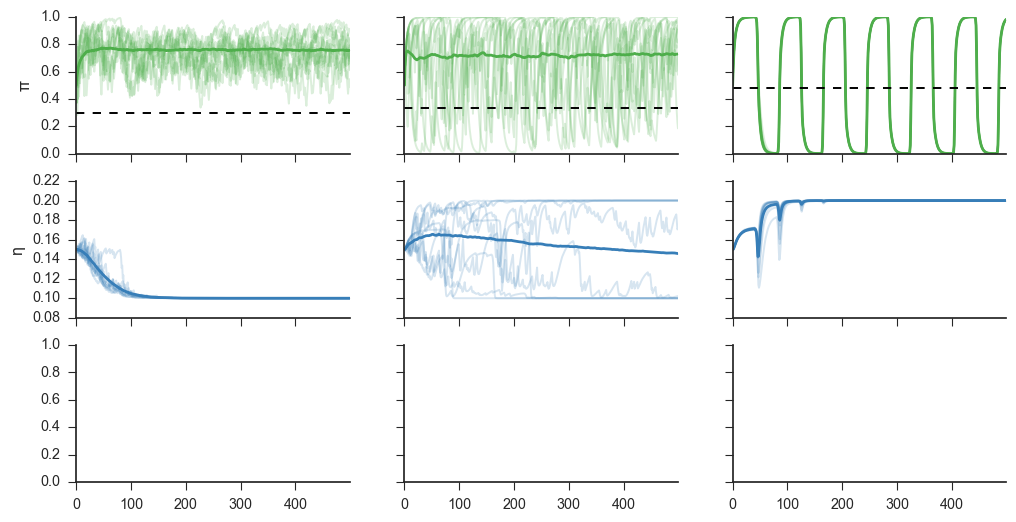

In [74]:
plot_simulations(df1);

# Genetic modifier

In [93]:
df = load_simulations('output3', False, False)
df.head()

,ID,N,env,n,t,ε,η1,η2,κ,μ1,μ2,π,π0,ω0,ω1
0,2016-11-22T20-24-28.098110,100000,B,1500,0,0.0,0.0,None,0.0001,0.1,None,0.499486,0.5,2.0,0.2
1,2016-11-22T20-24-28.098110,100000,B,1500,1,1.0,0.0,None,0.0001,0.1,None,0.577473,0.5,2.0,0.2
2,2016-11-22T20-24-28.098110,100000,B,1500,2,1.0,0.0,None,0.0001,0.1,None,0.482791,0.5,2.0,0.2
3,2016-11-22T20-24-28.098110,100000,B,1500,3,1.0,0.0,None,0.0001,0.1,None,0.398531,0.5,2.0,0.2
4,2016-11-22T20-24-28.098110,100000,B,1500,4,1.0,0.0,None,0.0001,0.1,None,0.321877,0.5,2.0,0.2


/Users/yoavram/miniconda3/envs/EvolRugAdaptLand2016/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


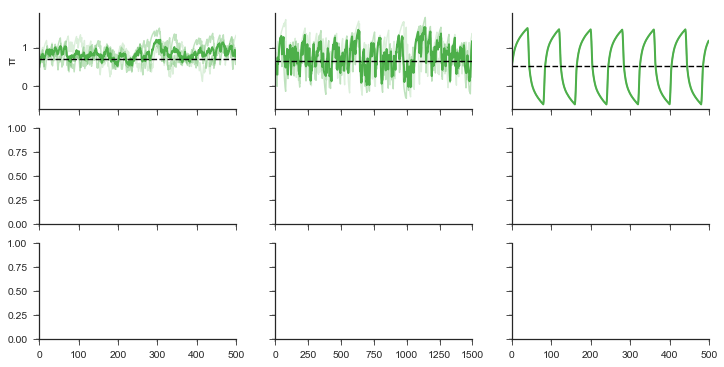

In [94]:
plot_simulations(df[df.μ1==0.1]);

/Users/yoavram/miniconda3/envs/EvolRugAdaptLand2016/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


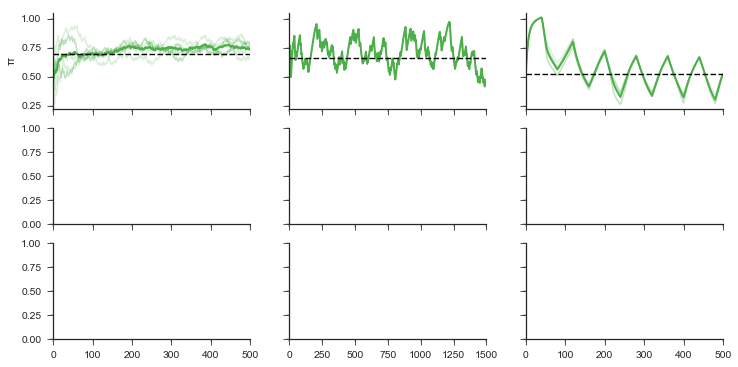

In [95]:
plot_simulations(df[df.μ1==0.01]);

# Genetic vs Epigenetic modifiers

In [4]:
df = load_simulations('output2', True, True)

In [6]:
df.head()

,ID,N,env,n,t,ε,η,η1,η2,κ,μ,μ1,μ2,π,π0,ω0,ω1
0,2016-11-22T20-31-04.039445,100000,B,1500,0,0.0,0.050000,0.1,0,0.0001,0.050000,0.0,0.1,0.500030,0.5,2.0,0.2
1,2016-11-22T20-31-04.039445,100000,B,1500,1,0.0,0.050030,0.1,0,0.0001,0.049964,0.0,0.1,0.594396,0.5,2.0,0.2
2,2016-11-22T20-31-04.039445,100000,B,1500,2,1.0,0.051104,0.1,0,0.0001,0.048891,0.0,0.1,0.668136,0.5,2.0,0.2
3,2016-11-22T20-31-04.039445,100000,B,1500,3,1.0,0.048698,0.1,0,0.0001,0.051309,0.0,0.1,0.556464,0.5,2.0,0.2
4,2016-11-22T20-31-04.039445,100000,B,1500,4,1.0,0.047264,0.1,0,0.0001,0.052735,0.0,0.1,0.465039,0.5,2.0,0.2


In [7]:
df.η2 = df.η2.astype(float)
df.η1.unique(), df.η2.unique(), df.μ1.unique(),df.μ2.unique()

(array([ 0.1 ,  0.  ,  0.99]),
 array([ 0. ,  0.1]),
 array([ 0.]),
 array([ 0.1 ,  0.01]))

In [84]:
for η1 in df.η1.unique():
    _df = df[df.η1==η1]
    for η2 in _df.η2.unique():
        __df = _df[_df.η2==η2]
        for μ1 in __df.μ1.unique():
            ___df = __df[__df.μ1==μ1]
            for μ2 in ___df.μ2.unique():
                ____df = ___df[___df.μ2==μ2]
                print("η1={}, η2={}, μ1={}, μ2={}, len={}".format(η1, η2, μ1, μ2, ____df.shape[0]))

η1=0.1, η2=0.0, μ1=0.0, μ2=0.1, len=1202000
η1=0.0, η2=0.1, μ1=0.0, μ2=0.1, len=1522000
η1=0.99, η2=0.0, μ1=0.0, μ2=0.01, len=28000


## η=0.1 μ=0.0 vs. η=0.0 μ=0.1

In [85]:
_df = df[(df.η1==0.1) & (df.η2==0) & (df.μ1==0) & (df.μ2==0.1)]
_df.shape

(1202000, 17)

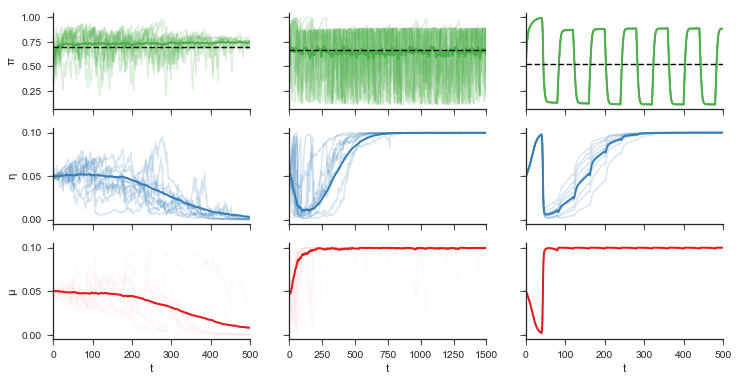

In [86]:
plot_simulations(_df);

## η=0.0 μ=0.0 vs. η=0.1 μ=0.1

In [87]:
_df = df[(df.η1==0) & (df.η2==0.1) & (df.μ1==0) & (df.μ2==0.1)]
_df.shape

(1522000, 17)

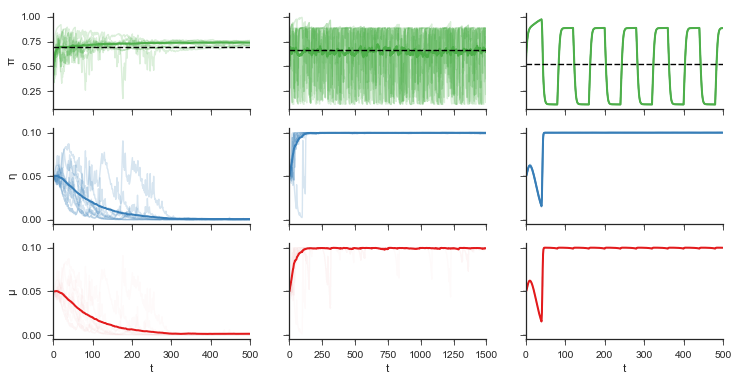

In [88]:
plot_simulations(_df);

## η=0.99 μ=0.0 vs. η=0.0 μ=0.01

In [89]:
_df = df[(df.η1==0.99) & (df.η2==0) & (df.μ1==0) & (df.μ2==0.01)]
_df.shape

(28000, 17)

(0, 0.0105)

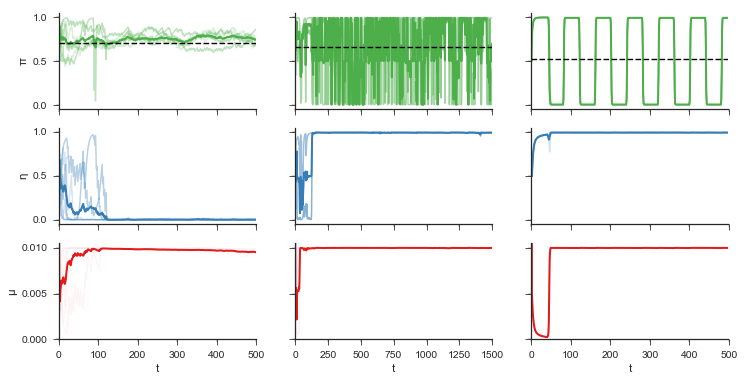

In [90]:
ax = plot_simulations(_df)
ax[2,0].set_ylim(0, 0.0105)

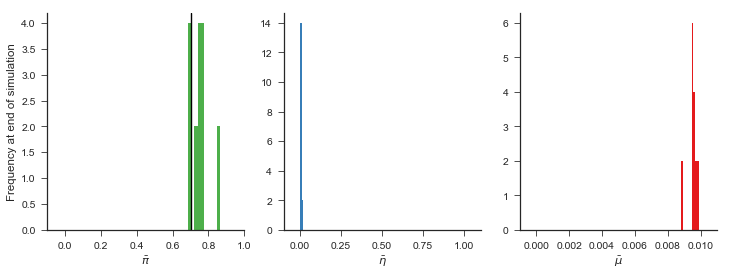

In [91]:
__df = _df[_df.env=='A']
tmax = __df.t.max()

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].hist(__df.loc[__df.t==tmax, 'π'], color=green)
ax[0].set_xlim(-0.1, 1)
ax[0].set_xlabel(r'$\bar{π}$')
ax[0].set_ylabel('Frequency at end of simulation')
ax[0].axvline(0.7, color='k')
ax[1].hist(__df.loc[__df.t==tmax, 'η'], color=blue, width=0.01)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_xlabel(r'$\bar{η}$')
ax[2].hist(__df.loc[__df.t==tmax, 'μ'], color=red)
ax[2].set_xlim(-0.001, 0.011)
ax[2].set_xlabel(r'$\bar{μ}$')
sns.despine()

# Diversity

In [2]:
def isogenic(N):
    x = np.ones(N) * 0.5
    return x

In [3]:
ε = np.array([0]*50+[1]*50+[0]*50+[1]*50+[0]*50+[1]*50+[0]*50+[1]*50)
π = simulation(10000, 400, 0.1, 0, 2.0, 0.2, 0.5, ε)

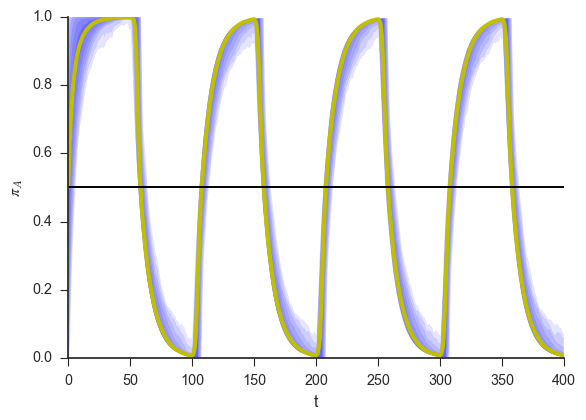

In [4]:
plot_π(π, ε);

In [37]:
def shannon(x):
    """Calculates Shannon Index: -sum_k{log(p_k) p_k} where k are value in input array x and p_k are frequencies of k in x.
    
    Parameters
    ----------
    x : np.ndarray
        array of values
        
    Returns
    -------
    float
        the shannon index
    """
    freqs = (np.unique(x).reshape(-1, 1) == x).mean(axis=1)
    nonzero_freqs = freqs[freqs.nonzero()]
    return -(nonzero_freqs * np.log(nonzero_freqs)).sum()

In [ ]:
shannon_idx = [shannon(π[t,:]) for t in range(π.shape[0])]

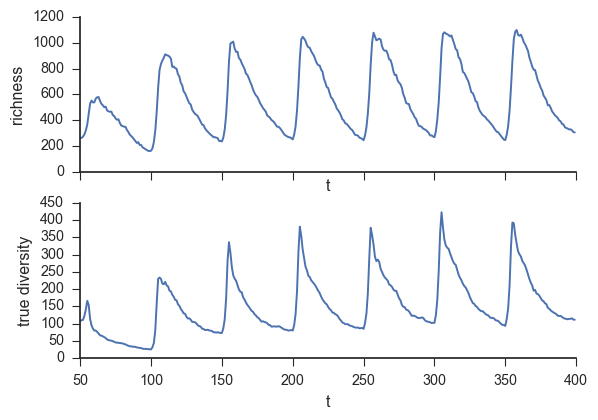

In [44]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
ax[0].plot(range(50, π.shape[0]), [len(np.unique(π[i,:])) for i in range(50, π.shape[0])])
ax[0].set(xlabel=('t'), ylabel=('richness'))
ax[1].plot(range(50, π.shape[0]), np.exp(shannon_idx[50:]))
ax[1].set(xlabel=('t'), ylabel=('true diversity'))
sns.despine()

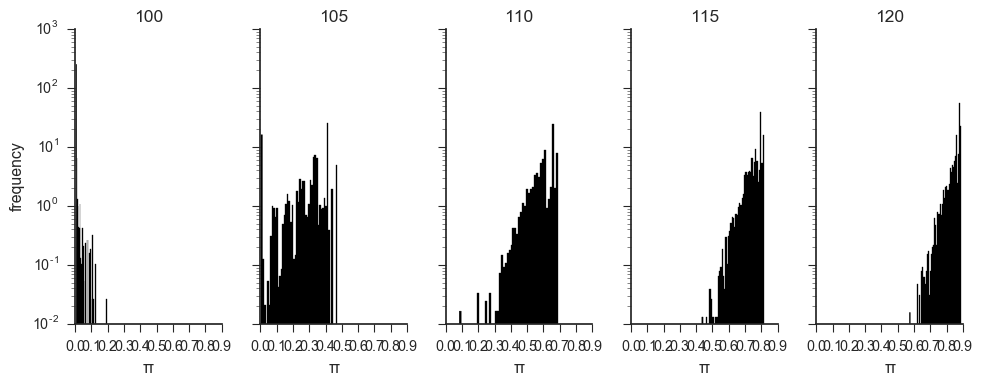

In [22]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10, 4)) 
bins = 50
for ax, t in zip(axes, [100,105,110,115,120]):
    ax.hist(π[t, :], bins=bins, color='k', normed=True, cumulative=False)
    ax.set(xlabel='π', title=t)
axes[0].set(ylabel='frequency', yscale='log')
fig.tight_layout()
sns.despine()

# Frequency based simulation

Specifics are in the [model description file](model.md).
The recurrence equation is:

$$
\bar{\omega}(t) \cdot  f_{t+1}(\pi) =
f_{t}\big( \frac{\pi-\eta}{1-\eta} \big) \cdot \frac{\pi-\eta}{1-\eta} \cdot \omega_A^{\epsilon(t)} + 
f_{t}\big( \frac{\pi}{1-\eta} \big) \cdot \big( 1- \frac{\pi}{1-\eta} \big) \cdot \omega_B^{\epsilon(t)}
$$

where $\bar{\omega}(t)$ is the integral of the right hand side over $0 \le \pi \le 1$.

<br>

![model diagram](graph.png)

In [275]:
N=100000
n=100
η=0.1
μ=0
ω0=2
ω1=0.2
π0=0.5

ϵ1 = np.random.choice(2, n, True, [0.7, 0.3])

ϵ, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵ[a: a + g] = 1
    a += g
ϵ2 = ϵ

ϵ3 = np.array(([0] * 40 + [1] * 40) * (n//80 + 1))

π1, f1 = deterministic(N, n, η, μ, ω0, ω1, π0, ε1)
π2, f2 = deterministic(N, n, η, μ, ω0, ω1, π0, ε2)
π3, f3 = deterministic(N, n, η, μ, ω0, ω1, π0, ε3)

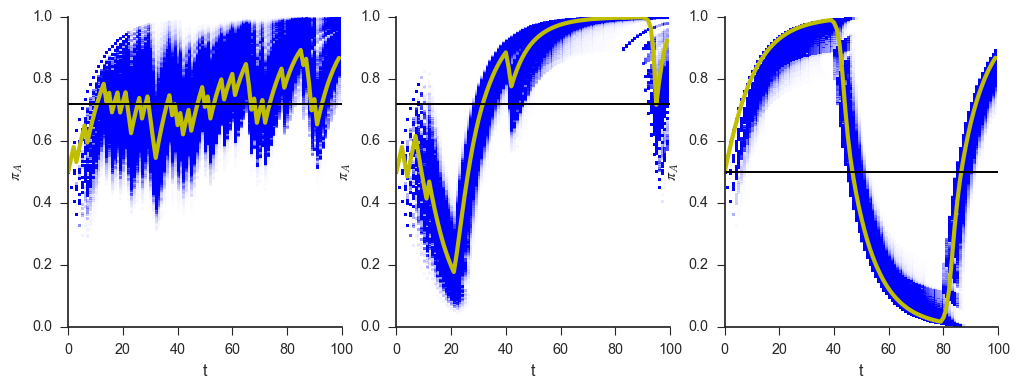

In [282]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

plot_π_deterministic(π1, f1, ϵ1, ax=ax[0])
plot_π_deterministic(π2, f2, ϵ1, ax=ax[1])
plot_π_deterministic(π3, f3, ϵ3, ax=ax[2]);

# Special cases

## Case 1: constant environment, uniform initial density, extreme selection, no learning

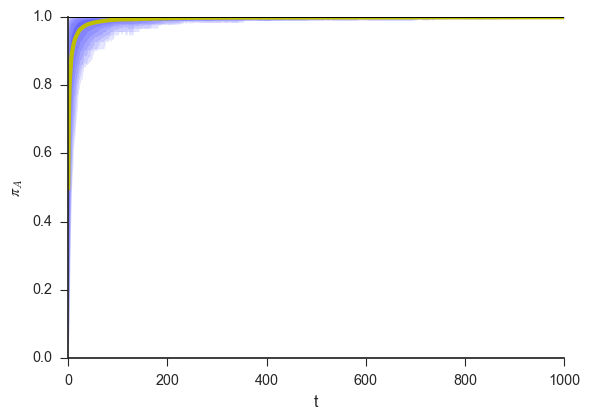

In [5]:
N=10000
n=1000
η=0
μ=0
ω0=1
ω1=0
π0=lambda N: np.random.uniform(0, 1, N)
ϵ = np.zeros(n, dtype=int)
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)

plot_π(π, ϵ)

## Case 2: constant environment, uniform initial density, non-extreme selection, no learning

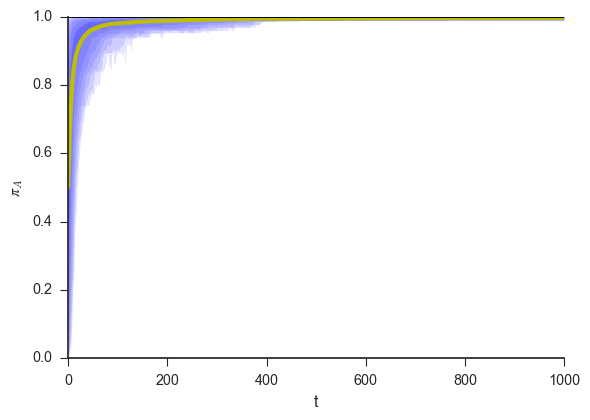

In [7]:
N=10000
n=1000
η=0
μ=0
ω0=1
ω1=0.5
π0=lambda N: np.random.uniform(0, 1, N)
ϵ = np.zeros(n, dtype=int)
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)

plot_π(π, ϵ)

## Case 3: constant environment, uniform initial density, extreme selection, with learning

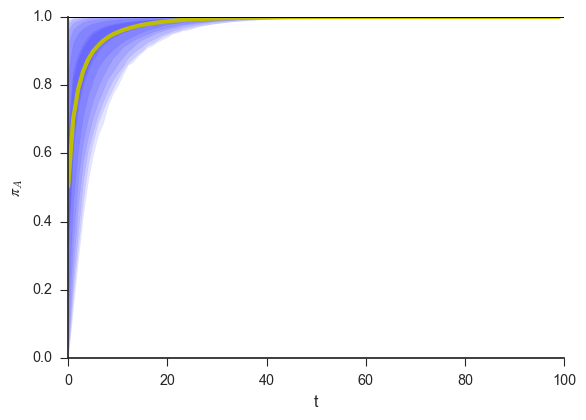

In [9]:
N=10000
n=100
η=0.1
μ=0
ω0=1
ω1=0
π0=lambda N: np.random.uniform(0, 1, N)
ϵ = np.zeros(n, dtype=int)
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)

plot_π(π, ϵ)

## Comparison of case 1 and case 3

In [30]:
N=10000
n=1000
η=0
μ=0
ω0=1
ω1=0
ϵ = np.zeros(n, dtype=int)
ηs = np.logspace(-5, 0, 6)

In [31]:
π0=lambda N: np.random.uniform(0, 1, N)
π1 = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)
π3s = [simulation(N, n, η, μ, ω0, ω1, π0, ϵ) for η in ηs]

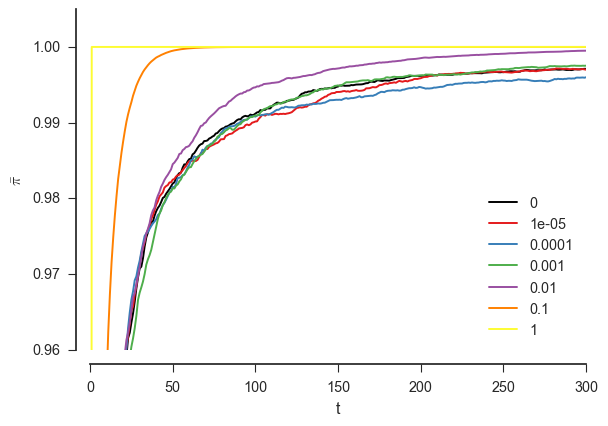

In [32]:
plt.plot(π1.mean(axis=1), '-k', label='0')
for π3, η, c in zip(π3s, ηs, sns.color_palette('Set1', 6)):
    plt.plot(π3.mean(axis=1), label='{:.2g}'.format(η), color=c)
plt.xlabel('t')
plt.ylabel(r'$\bar{\pi}$')
plt.ylim(0.96, 1.005)
plt.xlim(0, 300)
plt.legend(loc='lower right')
sns.despine(offset=10)

In [33]:
η = 0
π0 = lambda: uniform(500)
π1, f1 = deterministic(N, n, η, μ, ω0, ω1, π0, ϵ)
π3s = [deterministic(N, n, η, μ, ω0, ω1, π0, ϵ) for η in ηs]

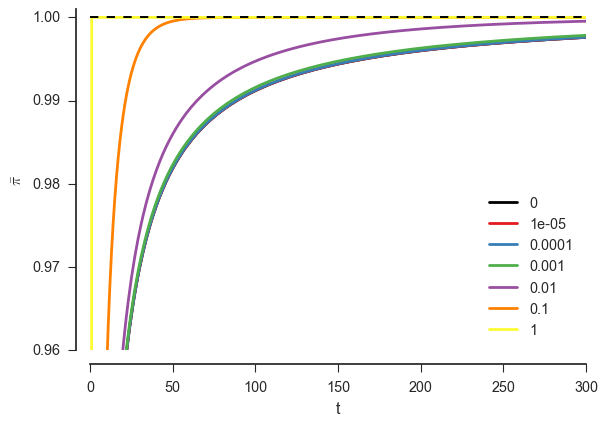

In [34]:
ax = plot_π_deterministic(π1, f1, ϵ, N, only_mean=True, color='k', label='0')
for (π3, f3), η, c in zip(π3s, ηs, sns.color_palette('Set1', 6)):
    plot_π_deterministic(π3, f3, ϵ, N, only_mean=True, label='{:.2g}'.format(η), color=c, ax=ax)
plt.xlabel('t')
plt.ylabel(r'$\bar{\pi}$')
plt.ylim(0.96, 1.001)
plt.xlim(0, 300)
plt.legend(loc='lower right')
sns.despine(offset=10)

## Case "4": constant environment, uniform initial density, non-extreme selection, with learning

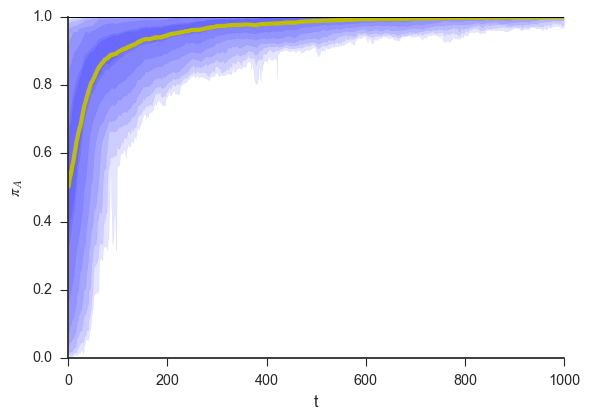

In [42]:
N=10000
n=1000
η=0.01
μ=0
ω0=1
ω1=0.9
π0=lambda N: np.random.uniform(0, 1, N)
ϵ = np.zeros(n, dtype=int)
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)

plot_π(π, ϵ)

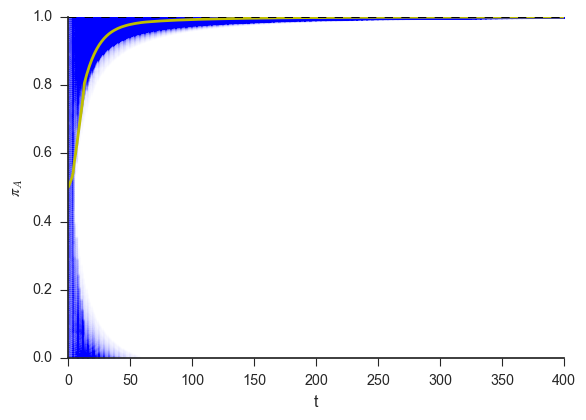

In [44]:
π0 = lambda: uniform(500)
π, f = deterministic(N, n, η, μ, ω0, ω1, π0, ϵ)
plot_π_deterministic(π, f, ϵ, N)
plt.xlim(0, 400);